In [101]:
from IPython.display import display

from io import StringIO
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.sandbox.distributions.extras as smde
import os
import pandas as pd

sns.set_style("whitegrid")


In [102]:
import statsmodels.sandbox.distributions.extras as extras
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt  
import numpy as np

def gaussian_expanded_inv_cdf(mu, sigma, skew, kurt, size=10000, sd_wide=10):
    f = smde.pdf_mvsk([mu, sigma**2, skew, kurt])
    x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=500)
    y = [f(i) for i in x]
    yy = np.cumsum(y) / np.sum(y)
    inv_cdf = interpolate.interp1d(yy, x, fill_value="extrapolate")
    return inv_cdf

In [103]:
    mu, sigma, skew, kurt = 0.0117, 0.1187, -0.616, 1.0308
    sd_wide = 20
    f = smde.pdf_mvsk([mu, sigma**2, skew, kurt])
    x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=500)
    y = [f(i) for i in x]
    yy = np.cumsum(y) / np.sum(y)
    inv_cdf = interpolate.interp1d(yy, x, fill_value="extrapolate")
    

(-0.8, 0.6)

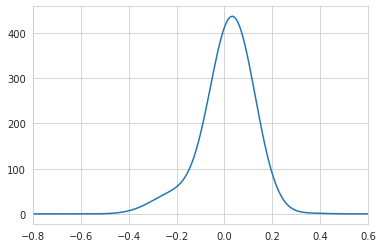

In [106]:
plt.plot(x, np.array(y) / 4. * 450)
plt.xlim(-0.8, 0.6)

(-0.8, 0.6)

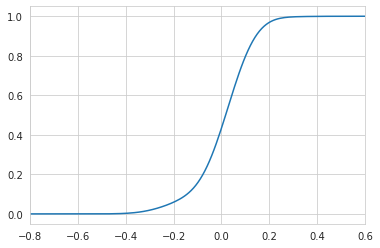

In [110]:
plt.plot(x, yy)
plt.xlim(-0.8, 0.6)

In [93]:
rr = inv_cdf(np.random.rand(10000))
print(ss.describe(rr))
print(np.sqrt(ss.describe(rr).variance))

DescribeResult(nobs=10000, minmax=(-0.2878168251923999, 0.23081145505369302), mean=-0.0071927672834554215, variance=0.0036694177125916323, skewness=-0.6887927715817334, kurtosis=0.7805262860515056)
0.06057571883677182


In [90]:
rv = ss.hypsecant(loc=-0.0052, scale=0.0603)

# rv.rvs(size=1000)
rv.stats(moments='mvsk')

(array(-0.0052), array(0.00897169), array(0.), array(2.))

In [ ]:
sns.distplot(generate_normal_four_moments(size=))

In [3]:
supply = pd.read_csv('20201007_da_co.processed.csv').set_index('id')
nsupply = len(supply)
print(supply.shape)
supply.head()

(3617, 3)


,node,capacity (MW),offer ($/MW)
id,,,
A3153_0,North,1.0,8.16
A3153_1,North,245.0,9.54
A3153_2,North,1.0,14.27
A3153_3,North,72.0,14.28
A3165_0,Central,180.0,10.77


In [23]:
supply['type'] = 'flexible'

supply['wind'] = supply['offer ($/MW)'] <= 0
supply.groupby(['node', 'wind'])['capacity (MW)'].agg([np.sum, len])

sum     len
node    wind                  
Central False  70603.4  1605.0
        True   14683.6    67.0
North   False  25164.8  1006.0
        True   27189.0   207.0
South   False  47638.0   727.0
        True     239.5     5.0

In [28]:
dist = stats.pearson3(loc=-0.0155, scale=0.0751, skew=-0.0720, k=3.1036)

TypeError: _parse_args() got an unexpected keyword argument 'k'

In [ ]:
demand = pd.read_csv('20201007_bids_cb.processed.csv').set_index('id')
ndemand = len(demand)
assert demand.node.isin(nodes).all()
print(demand.shape)
demand.head()